# INM702 Coursework Task 1
### Aaron Mir (Student Number: 160001207)


<img src="Task1(1).jpg" alt="Task1(1)" width="700"/>
<img src="Task1(2).jpg" alt="Task1(2)" width="700"/>
<img src="Task1(3).jpg" alt="Task1(3)" width="700"/>
<img src="Task1(4).jpg" alt="Task1(4)" width="700"/>


The first task tests your Python skills. You need to develop a simple game consisting of a rectangular grid (of size height x width) where each cell has a random integer value between 0 and 9. An agent starts at the upper-left corner of the grid and must  reach the lower-right corner of the grid as fast as possible. You can implement one of the two (or both, for no extra point) game modes:

    • The time spent on a cell is the number on this cell
    • The time spent on a cell is the absolute of the difference between the previous cell the agent was on and the current cell it is on

In order to solve this problem, you will provide 3 algorithms:

    • A first baseline of your choosing. E.g. it can be any search algorithm, or an algorithm using heuristics. 
    It doesn’t have to perform fast or well, but  should be better than random movements.
    • Dijkstra's algorithm
    • Ant colony optimization algorithm

You should describe the algorithms and compare them. Are they always solving the problem? How long do they take depending on the size of the maze?


In [43]:
from __future__ import division
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import animation
import numpy as np
import torch 
import torchvision as tv
import sys
import random
import copy
np.set_printoptions(threshold=sys.maxsize)

print(f"Python: {sys.version}")
print(f"Numpy Version: {np.__version__}")
print(f"PyTorch Version: {torch.__version__}")
print(f"Torchvision Version: {tv.__version__}")
# Use assert to test functions

Python: 3.8.1 (tags/v3.8.1:1b293b6, Dec 18 2019, 23:11:46) [MSC v.1916 64 bit (AMD64)]
Numpy Version: 1.18.1
PyTorch Version: 1.6.0+cu101
Torchvision Version: 0.7.0+cu101


In [52]:
class IntMaze():
    def __init__ (self, height, width):  #add Agent name and Game Mode
        self.height = height
        self.width = width
        #self.mode = mode
        #self.agent = agent

    def create_maze(self):
        maze = np.matrix(np.random.randint(0, 10, size = (self.height, self.width)))
        print(maze)
        return maze

    def start_game(self):
        pass
    
    def maze_reset(self):
        pass
    
    def travel_time(self):
        pass

    def plot_maze(self): # agent has colour red which is slightly transparent? 
        fig = plt.figure()
        cmap = colors.ListedColormap(['white','green', '#ffff99', 'gold','orange', '#386cb0', '#550011', 'purple', '#f0027f', '#386cb0'])
        plt.imshow(self.create_maze(), cmap = cmap, alpha = 0.5) 
        plt.colorbar(cmap=cmap)
        #use funcanimation to show agent moving along the grid?
        plt.show()   

[[7 8 9 2 8 4 2 9 6]
 [3 1 7 9 0 9 7 4 5]
 [1 5 8 3 9 2 1 4 8]
 [1 9 2 3 2 3 5 4 7]
 [9 1 5 8 1 1 9 0 9]
 [0 0 0 6 8 2 2 0 7]
 [7 5 2 8 7 5 3 9 8]
 [2 5 3 1 0 1 9 2 0]
 [0 7 8 3 2 5 6 3 6]]


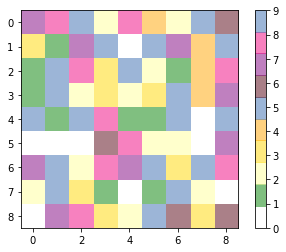

In [53]:
Maze = IntMaze(9, 9)
Maze.plot_maze()

In [ ]:
class Agent():
    def __init__ (self, name):
        self.name = name

    def moveUp(self):
        pass
    
    def moveDown(self):
        pass
    
    def moveLeft(self):
        pass
    
    def moveRight(self):
        pass

    def time_wait(self):
        pass